## Problem Definition

In [2]:
TRAIN_POLICY: bool=False
SEED=42
RADIUS=2 #radius of the goal locations on the circle.

from garage.experiment.deterministic import set_seed
from garage.envs.point_env import PointEnv
from src.learning.inference.utils import sample_traj_of_env, sample_meta_traj
from src.plotting.rl.circle import plot_rollouts_on_circle
from src.utils import GarageToGymWrapper

from constants import FIG_HEIGHT, DPI, LABEL_FONT_SIZE

set_seed(SEED)
N_TASKS=3
RANDOM_SEED=42
CircleRotation=PointEnv()
train_goal_locations=CircleRotation.sample_tasks(N_TASKS)

task_1=PointEnv()
task_1.set_task(train_goal_locations[0])



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


In [6]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env

# Training setup
N_ENVS=2 #does not learn for more envs as environment too simple!
N_STEPS=50_000

task_1_gym=GarageToGymWrapper(task_env=task_1)

if TRAIN_POLICY:
    vec_env = make_vec_env(lambda: task_1_gym, n_envs=N_ENVS, seed=RANDOM_SEED)
    policy_base = SAC("MlpPolicy", vec_env, verbose=1, seed=RANDOM_SEED, batch_size=128)
    policy_base.learn(total_timesteps=N_STEPS)
    policy_base.save("sac_circle_rotation_task_1")
else:
    policy_base = SAC.load("sac_circle_rotation_task_1", env=task_1_gym)

/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


## Evaluate policy

In [8]:
# Evaluate policy

N_TEST_TASKS: int=20
test_tasks = CircleRotation.sample_tasks(N_TEST_TASKS)
test_tasks_flat = [d['goal'] for d in test_tasks]
train_tasks_flat = [train_goal_locations[0]["goal"]]

test_envs = [PointEnv() for _ in range(N_TEST_TASKS)]
for env, task in zip(test_envs, test_tasks):
    env.set_task(task)
test_envs = [GarageToGymWrapper(task_env=env) for env in test_envs]
train_envs=[task_1_gym]

train_pis=[policy_base for _ in range(len(train_envs))]
test_pis=[policy_base for _ in range(len(test_envs))]

rollouts=sample_meta_traj(train_envs=train_envs, 
                          test_envs=test_envs,
                          train_pis=train_pis,
                          test_pis=test_pis)

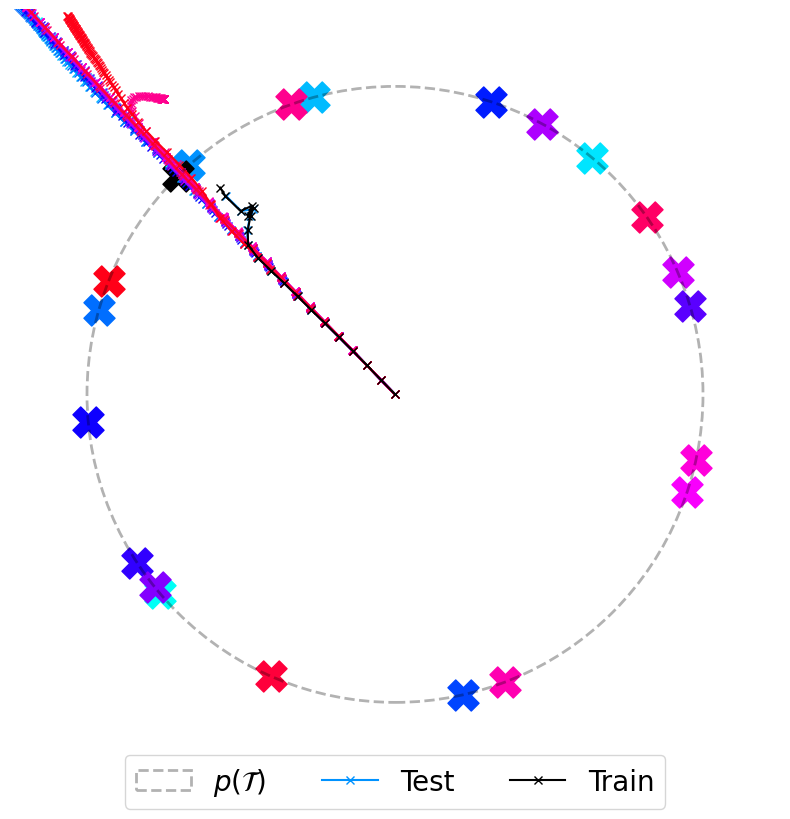

In [9]:
plot_rollouts_on_circle(train_trajectories=rollouts["train"]["states"],
                        # test_trajectories=[],
                        # test_goal_locations=[],
                        test_trajectories=rollouts["test"]["states"],
                        train_goal_locations=train_tasks_flat,
                        test_goal_locations=test_tasks_flat,
                        fig_height=FIG_HEIGHT, label_font_size=LABEL_FONT_SIZE, dpi=DPI,
                        legend=True,
                        savepath=None
                        # savepath="circle_nav_vanilla_meta_rl"
                        )

## Hereditary Symmetry

In [14]:
import numpy as np

LG = lambda theta : np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

# Calculate rotation angle of goal location
rot_angle_from_goal = lambda goal_location: np.arctan2(goal_location[1], goal_location[0])
train_tasks_rotations= [rot_angle_from_goal(goal_location) for goal_location in train_tasks_flat]
test_tasks_rotations = [rot_angle_from_goal(goal_location) for goal_location in test_tasks_flat] 

